<a href="https://colab.research.google.com/github/gitudaniel/fastai-course-notes/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- A model is defined by its independent and dependent variables, along with its loss function.

- To be able to move beyond fixed applications, to crafting your own novel solutions to novel problems, it helps to really understand the data blocks API.

- As an example, let's consider the problem of *image regression*.

- This refers to learning from a dataset where the independent variable is an image, and the dependent variable is one or more floats.

- Often we see people treating image regression as a whole separate application--but as you'll see here, we can treat it as just another CNN on top of the data block API.

- We're going to jump straight to a somewhat tricky variant of image regression and do a *key point* model.

- A *key point* refers to a specific location represented in an image--in this case, we'll be looking for the center of the person's face in each image.

- That means we'll actually be predicting *two* values for each image: the row and column of the face center.

## Assemble the data

- We will use the Biwi Kinect Head Pose Dataset for this section.

- Let's begin by downloading the dataset:

In [ ]:
!pip install --upgrade fastai

     |████████████████████████████████| 188 kB 7.4 MB/s 
     |████████████████████████████████| 53 kB 3.1 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!pip install fastbook

     |████████████████████████████████| 720 kB 10.3 MB/s 
     |████████████████████████████████| 1.2 MB 48.6 MB/s 
     |████████████████████████████████| 46 kB 5.4 MB/s 
     |████████████████████████████████| 51 kB 353 kB/s 


In [ ]:
from fastai.vision.all import *
from fastbook import *

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
Path.BASE_PATH = path

- Let's see what we've got.

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

- There are 24 directories numbered from 01 to 24 (they correspond to the different persons photographed) and a corresponding .obj file (we won't need them here).

- Let's take a look inside one of these directories:

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

- Inside the subdirectories, we have different frames, each of them come with an image (`\_rgb.jpg`) and a pose file (`\_pose.txt`).

- We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file.

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('03/frame_00085_pose.txt')

- `PILImage.create()` is the fastai way to create a `PIL` image.

- In computer vision the images are represented columns by rows not rows by columns which can get a little confusing.

- PyTorch and Numpy tensors and arrays are rows by columns.

- We can have a look at our first image:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

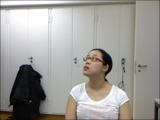

In [ ]:
im.to_thumb(160)

- The Biwi dataset website explains the format of the pose text file associated with each image, which shows the location of the center of the head.

- For our purposes, the details of this aren't important, so we'll just show the function we use to extract the head center point.

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

- The function returns the coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

tensor([370.5308, 246.5122])

- We can pass that function to `DataBlock` as `get_y`, since it is responsible for labelling each item.

- We'll resize the images to half their input size just to speed up training a bit.

- It is important to note that we should not just use a random splitter.

- This is because the same person can appear in multiple images in this dataset -- but we want to ensure that our model can generalize to people it hasn't seen yet.

- The validation set should contain one or more people that don't appear in the training set.

- Each folder in the dataset contains the images for one person. We can therefore create a splitter function which returns true for just one person, resulting in a validation set containing just that person's images.

- Unlike previous data block examples, the second block is a `PointBlock`.

- This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images.

In [ ]:
# Normalize.from_stats(*imagenet_stats) -> subtract the mean and divide by the
# standard deviation of the original dataset the pretrained model used (imagenet)
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

> fastai automatically and correctly applies data augmentation to coordinates. If you're working with another library, you may need to disable data augmentation for these kinds of problems.

- Before doing any modelling, we should look at our data to confirm it seems ok:

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


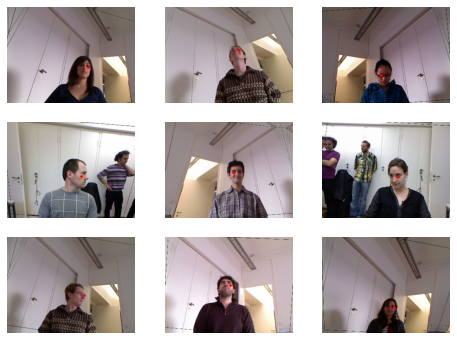

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

- As well as looking at the batch visually, it's also a good idea to look at the tensors visually (especially as a student, it will help you clarify your understanding of what your model is really seeing).

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

- `xb.shape -> torch.Size([64, 3, 240, 320])` corresponds to:
    - 64 items in our mini batch (number of rows)
    - 3 channels for our images (Red, Green, Blue)
    - pixel size (240 rows x 320 columns)

- `yb.shape -> torch.Size([64, 1, 2])` corresponds to:
    - 64 items in our mini batch
    - a 1 x 2 matrix representing our coordinates for the center (a single point with 2 things in it)

- It is important to understand why these are the shapes for our mini-batches

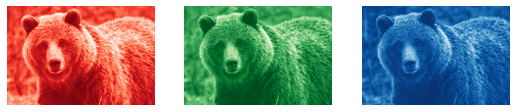

In [ ]:
im = image2tensor(Image.open('drive/MyDrive/Colab Notebooks/Fastai/images/grizzly.jpg'))
_, axs = subplots(1,3)
for bear, ax, color in zip(im, axs, ('Reds', 'Greens', 'Blues')):
  show_image(255-bear, ax=ax, cmap=color)

- Here's an example of one row from the dependent variable:

In [ ]:
yb[0]

TensorPoint([[-0.0983, -0.2513]], device='cuda:0')

- As you can see, we haven't had to use a separate *image regression* application; all we've had to do is label the data, and tell fastai what kind of data the independent and dependent variables represent.

- It's the same for creating our `Learner`. We will use the same function as before, this time with just a new parameter and we'll be ready to train our model

## Training a model

- We can use the `cnn_learner` to create our `Learner`.

- Coordinates in fastai and PyTorch are always rescaled between -1 and +1. We use `y_range=(-1, 1)` to tell fastai the range of our targets

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


- `y_range` is implemented in fastai using `sigmoid_range`, which is defined as:

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi - lo) + lo

- This sets the final layer of the model, if `y_range` is defined.

- Here's what it looks like:

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


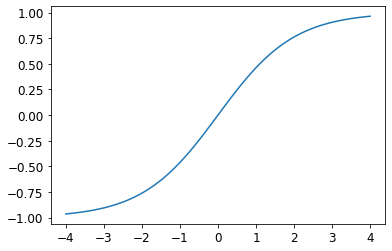

In [ ]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

- We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it chose for us:

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

- This makes sense, since when coordinates are used as dependent vairables, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean-squared error loss) does.

- If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

- Note that we also didn't speciry any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root).

- We can pick a good learning rate with the Learning Rate Finder:

SuggestedLRs(valley=0.0014454397605732083)

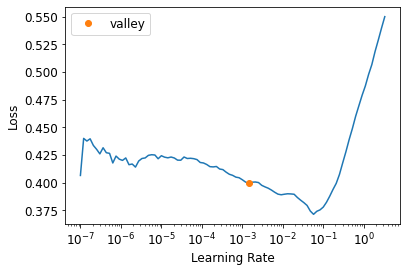

In [ ]:
learn.lr_find()

- We'll try an LR of `1e-2`:

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047329,0.002127,02:02


epoch,train_loss,valid_loss,time
0,0.007761,0.003892,02:11
1,0.003015,0.000361,02:13
2,0.001403,0.000223,02:12


- Generally, when we run this, we get a loss of around `0.0001`, which corresponds to an average coordinate prediction error of:

In [ ]:
math.sqrt(0.0001)

0.01

- This sounds very accurate, but most importantly, we should look at our results with `Learner.show_results`.

- The left side is actual (ground truth) and the right side is our model's prediction

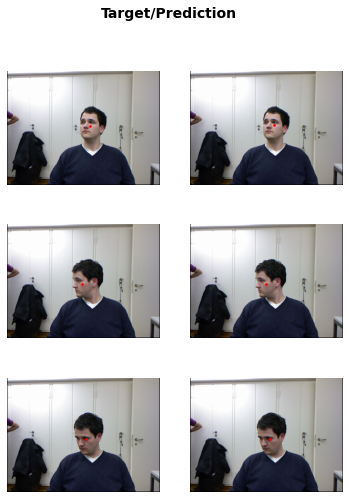

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6, 8))

- In this exercise, we're fine-tuning an image classification model (Imagenet) to become an image regression model.

- This works well because an imagenet classification model must have learnt a lot about how images look like and where pieces of them are.

- Built into every imagenet pretrained model is all this capability that it had to learn for itself. Asking it to use that capability to figure out where something is, is just not that hard for it.